<a href="https://colab.research.google.com/github/sjsoumil/Projects/blob/main/Project_Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LSTM, Embedding, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
# GlobalMaxPooling  helps in reducing dims and getting the importants Features over a long sequences
# LSTM Long short term memory  maintains information over long sequences vanishes gradient problem
# Embedding  convert categorical values into vectors of fixed size
# Dropout prevent overfitting by dropping the neurons during training periods
# Bidrectional process input data in both forward and backward direction
# BatchNormalization improves training speed and stability by convert data into mini batches with zero mean and unitvariannce
# Tokenizer converts sequence of words into individual units called tokens finally converts text data in numerical data for data modelling
# pad sequences is used to make every input of the same length
# EarlyStopping stops the training process once the performance on the validation set stops improving hence prevents overfitting
# LearningRateScheduler adjust the learning rate


In [ ]:
# Load the dataset and drop unnecessary columns
data = pd.read_csv("/content/drive/MyDrive/train.csv")
data.drop(["id", "title", "author"], axis=1, inplace=True)

In [ ]:
data.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


from matplotlib import pyplot as plt
_df_0['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='label', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Assuming your target variable is 'target' and text data is in 'text' column
X = data['text']
Y = data['label']

In [ ]:
# Tokenize the text data
MAX_WORD_VOCAB = 1000
tokenizer = Tokenizer(num_words=MAX_WORD_VOCAB)
# Converting each element into a string
X = [str(text) for text in X]
tokenizer.fit_on_texts(X)
# COnverting texts into sequences of integers
sequences = tokenizer.texts_to_sequences(X)
# assigning index to each token
word2ind = tokenizer.word_index
V = len(word2ind)
print(f"Length of word2ind: {V}")

Length of word2ind: 238051


In [ ]:
# Making all data of the same length
data_pad = pad_sequences(sequences)
T = data_pad.shape[1]
print("Shape of the tesnor is :",data_pad.shape)

Shape of the tesnor is : (20800, 18171)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data_pad, Y, test_size=0.2, random_state=42)

In [ ]:
# Define the model with bidirectional LSTM, Batch Normalization, and increased complexity
D = 20  # Increase embedding dimension
M = 15  # Increase LSTM units
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Bidirectional(LSTM(M, return_sequences=True))(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(i, x)

# Compile the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:

# Implement learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback_lr_scheduler = LearningRateScheduler(scheduler)


In [ ]:
# Implement early stopping
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:

# Train the model with callbacks and small batches
r = model.fit(X_train, Y_train,
              epochs=2,  # Increase epochs
              validation_data=(X_test, Y_test),
              callbacks=[callback_lr_scheduler, callback_early_stopping],
              batch_size=32)  # Specify batch size


Epoch 1/2
520/520 [==============================] - 463s 890ms/step - loss: 0.0104 - accuracy: 0.9977 - val_loss: 0.0754 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 2/2
520/520 [==============================] - 497s 956ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0794 - val_accuracy: 0.9772 - lr: 0.0010


130/130 [==============================] - 48s 366ms/step


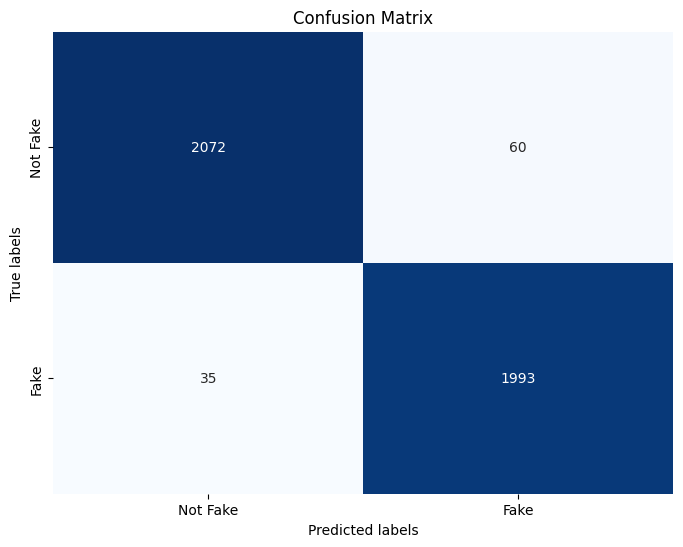

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2132
           1       0.97      0.98      0.98      2028

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160

130/130 [==============================] - 51s 391ms/step - loss: 0.0794 - accuracy: 0.9772
Test Loss: 0.07936615496873856
Test Accuracy: 0.9771634340286255


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test data
Y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
Y_pred_binary = np.round(Y_pred).flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fake', 'Fake'],
            yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model
print(classification_report(Y_test, Y_pred_binary))

# Alternatively, you can use TensorFlow's inbuilt functionality to evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


In [ ]:
# true=pd.read_csv("/content/drive/MyDrive/Fake n/true.csv")
# true.head()

# true.drop(["date", "subject"], axis=1, inplace=True)
# true.shape
# y_test[len()]
# # Y_pred = model.predict(true)
# # Y_pred_binary = np.round(Y_pred).flatten()
# # Assuming y_test is a NumPy array
# # Set all values in y_test to 1
# y_test.fill(1)

# # Flatten y_test
# y_test_flat = y_test.flatten()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, Y_test):
    # Predict on test data
    Y_pred = model.predict(X_test)

    # Convert probabilities to binary predictions
    Y_pred_binary = np.round(Y_pred).flatten()

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(Y_test, Y_pred_binary)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fake', 'Fake'],
                yticklabels=['Not Fake', 'Fake'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Evaluate the model
    print(classification_report(Y_test, Y_pred_binary))

    # Alternatively, you can use TensorFlow's inbuilt functionality to evaluate the model
    loss, accuracy = model.evaluate(X_test, Y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')
